1.1 IMPORTING DEPENDENCIES

In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # If you use OpenCV for image handling
#from PIL import Image  # If you use PIL for image handling
import os  # For handling file paths


1.2 LOAD DATASET

In [2]:
# Example for loading data from a directory
dataset_dir = '/content/drive/MyDrive/myIMgcls/flooddataset'

# Listing the classes (flood and non-flood)
classes = ['FLOOD IMAGES', 'non flood images']
data = []
labels = []

for category in classes:
    folder_path = os.path.join(dataset_dir, category)
    label = classes.index(category)  # Label flood as 0, non_flood as 1

    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        image = cv2.imread(img_path)  # Use cv2 for image loading
        image = cv2.resize(image, (128, 128))  # Resize to standard size for CNN
        data.append(image)
        labels.append(label)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Dataset shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Dataset shape: (835, 128, 128, 3)
Labels shape: (835,)


1.3 VISUALIZE DATA

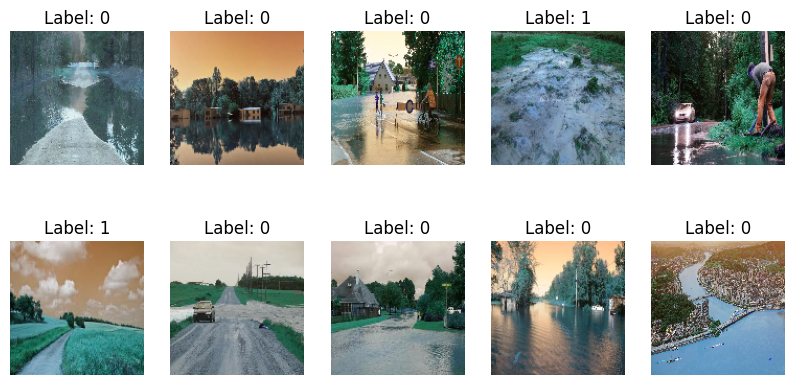

In [3]:

# Shuffle the dataset and labels together
indices = np.arange(len(data))  # Create an array of indices from 0 to the length of the data
np.random.shuffle(indices)  # Shuffle the indices randomly

# Re-arrange the data and labels according to the shuffled indices
shuffled_data = data[indices]
shuffled_labels = labels[indices]

# Display the first 10 images with their shuffled labels
plt.figure(figsize=(10, 5))

# First 5 images
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(shuffled_data[i])
    plt.title(f"Label: {shuffled_labels[i]}")
    plt.axis('off')

# Next 5 images
for i in range(5, 10):
    plt.subplot(2, 5, i+1)
    plt.imshow(shuffled_data[i])
    plt.title(f"Label: {shuffled_labels[i]}")
    plt.axis('off')

plt.show()


In [4]:
# Checking the number of images in each class
flood_count = len(os.listdir(os.path.join(dataset_dir, 'FLOOD IMAGES')))
non_flood_count = len(os.listdir(os.path.join(dataset_dir, 'non flood images')))

print(f"Number of flood images: {flood_count}")
print(f"Number of non-flood images: {non_flood_count}")



Number of flood images: 493
Number of non-flood images: 342


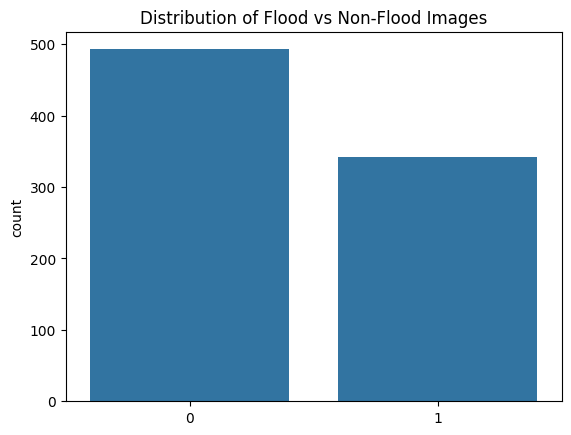

In [5]:
# Visualize distribution of flood vs non-flood images
sns.countplot(x=labels)
plt.title("Distribution of Flood vs Non-Flood Images")
plt.show()

1.4 ADRESSING CLASS IMBALANCE...

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Separate flood and non-flood images and labels
flood_data = data[labels == 0]  # Flood class images
non_flood_data = data[labels == 1]  # Non-flood class images

# Number of images in each class
num_flood = len(flood_data)
num_non_flood = len(non_flood_data)

# Augment the non-flood class to match the flood class size
augmentation_needed = num_flood - num_non_flood


In [7]:
# Define the data augmentation for the non-flood images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data augmentation generator on the non-flood data
datagen.fit(non_flood_data)


In [8]:
# Generate augmented images for the non-flood class
augmented_non_flood_data = []
augmented_labels = []

# Generate exactly the number of augmented images needed
i = 0
while len(augmented_non_flood_data) < augmentation_needed:
    image = non_flood_data[i % num_non_flood]  # Loop over non-flood data cyclically
    augmented_image = datagen.random_transform(image)  # Apply augmentation
    augmented_non_flood_data.append(augmented_image)
    augmented_labels.append(1)  # Label for non-flood class
    i += 1



In [9]:
x=len(augmented_non_flood_data)
x

151

In [10]:
augmented_non_flood_data = np.array(augmented_non_flood_data)
augmented_labels = np.array(augmented_labels)


# Combine the original and augmented data
balanced_data = np.concatenate((flood_data, non_flood_data, augmented_non_flood_data), axis=0)
balanced_labels = np.concatenate((np.zeros(num_flood), np.ones(num_non_flood), augmented_labels), axis=0)

In [11]:
# Shuffle the dataset to ensure randomness
indices = np.arange(len(balanced_data))
np.random.shuffle(indices)

balanced_data = balanced_data[indices]
balanced_labels = balanced_labels[indices]

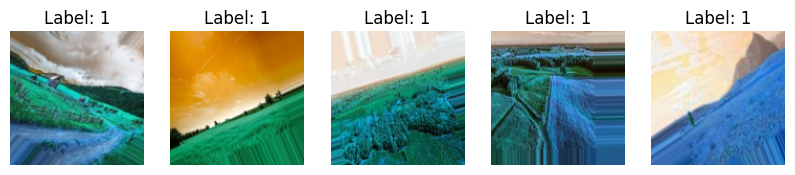

In [12]:
# Display a few images  to verify
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_non_flood_data[i])
    plt.title(f"Label: {augmented_labels[i]}")
    plt.axis('off')

plt.show()

In [13]:
num_flood = len(flood_data)
num_flood

493

In [14]:
total_nonflood = np.concatenate((non_flood_data, augmented_non_flood_data), axis=0)
yy=len(total_nonflood)
yy

493

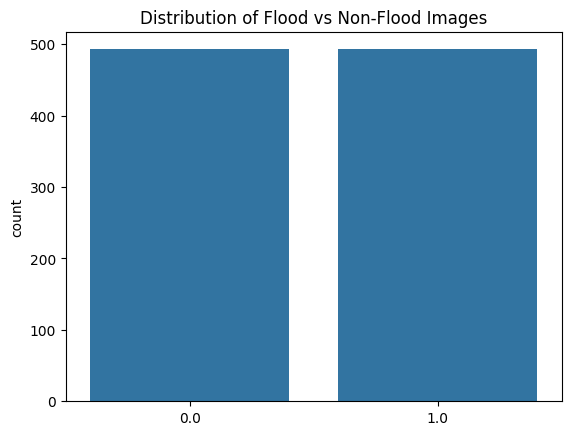

In [15]:
#Visualize distribution once more
sns.countplot(x=balanced_labels)
plt.title("Distribution of Flood vs Non-Flood Images")
plt.show()

1.5 DATA PREPROCESSING

In [16]:
# Normalize the data (scale pixel values to range 0-1)
data = balanced_data / 255.0

# Print to verify normalization
print(f"Min pixel value: {data.min()}")
print(f"Max pixel value: {data.max()}")


Min pixel value: 0.0
Max pixel value: 1.0


In [17]:
data.shape

(986, 128, 128, 3)

In [18]:
data

array([[[[0.57254902, 0.56862745, 0.56470588],
         [0.56862745, 0.56078431, 0.5254902 ],
         [0.84313725, 0.82352941, 0.75294118],
         ...,
         [0.14117647, 0.14509804, 0.13333333],
         [0.20392157, 0.21176471, 0.21176471],
         [0.27058824, 0.27058824, 0.23137255]],

        [[0.52156863, 0.5372549 , 0.5254902 ],
         [0.5254902 , 0.52941176, 0.50588235],
         [0.54901961, 0.54117647, 0.50196078],
         ...,
         [0.14117647, 0.14509804, 0.13333333],
         [0.20392157, 0.21176471, 0.21176471],
         [0.28235294, 0.28235294, 0.24313725]],

        [[0.54509804, 0.57254902, 0.55294118],
         [0.54901961, 0.56470588, 0.55686275],
         [0.49803922, 0.49803922, 0.49803922],
         ...,
         [0.1372549 , 0.14117647, 0.12941176],
         [0.21176471, 0.21960784, 0.21960784],
         [0.29803922, 0.29803922, 0.25882353]],

        ...,

        [[0.83529412, 0.84313725, 0.84705882],
         [0.78823529, 0.79607843, 0.8       ]

2.0 SPLIT TEST AND TRAIN DATA

In [19]:
X = data
y = balanced_labels

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and remaining (30%) for validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the remaining 30% into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Verify the split sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 690
Validation set size: 148
Test set size: 148


2.1 BUILD CNN MODEL

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Add the Input layer first
model.add(Input(shape=(128, 128, 3)))

# 1st Convolutional Block: Conv + ReLU + MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Block: Conv + ReLU + MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Block: Conv + ReLU + MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 3D output to 1D
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Add dropout to reduce overfitting
model.add(Dropout(0.5))

# Output layer for binary classification (sigmoid activation for binary)
model.add(Dense(1, activation='sigmoid'))




In [22]:
from tensorflow.keras.optimizers import Adam

# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Early stopping to stop the training when validation continues performing poorly


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

2.3 TRANING THE MODEL..


In [24]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1         # Verbosity level: 1 shows progress bars, 0 for silent, 2 for epoch only
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - accuracy: 0.5302 - loss: 0.6933 - precision: 0.5396 - recall: 0.5392 - val_accuracy: 0.6419 - val_loss: 0.6503 - val_precision: 0.9565 - val_recall: 0.2973
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6908 - loss: 0.6067 - precision: 0.7617 - recall: 0.6028 - val_accuracy: 0.7365 - val_loss: 0.5384 - val_precision: 0.7966 - val_recall: 0.6351
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7598 - loss: 0.5095 - precision: 0.7819 - recall: 0.7283 - val_accuracy: 0.7635 - val_loss: 0.5109 - val_precision: 0.7349 - val_recall: 0.8243
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7730 - loss: 0.4583 - precision: 0.7909 - recall: 0.7500 - val_accuracy: 0.7703 - val_loss: 0.4735 - val_precision: 0.7857 - val_recall: 0.7432
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7670 - loss: 0.4479 - precision: 0.8018 - recall: 0.7184 - val_accuracy: 0.7905 - val_loss: 0.464

2.4 PERFORMANCE VISUALIZATIONS

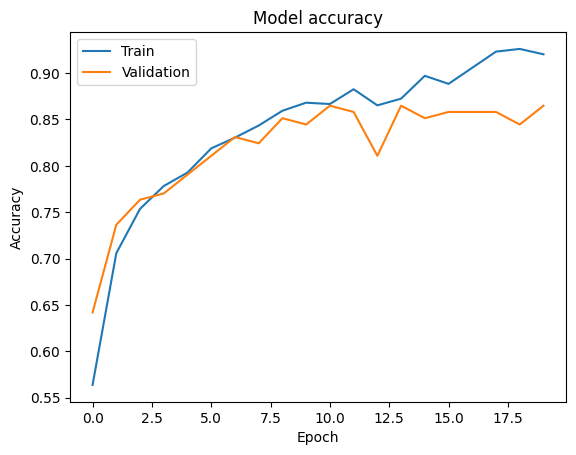

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




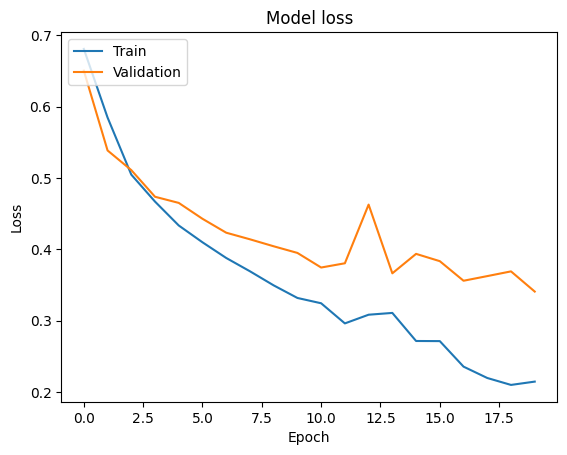

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

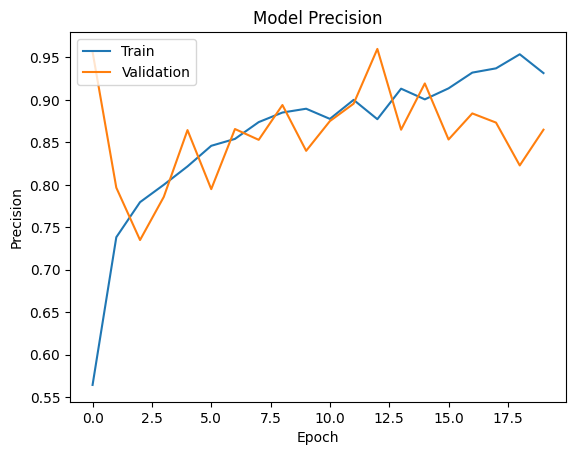

In [27]:
# Plot training & validation loss values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

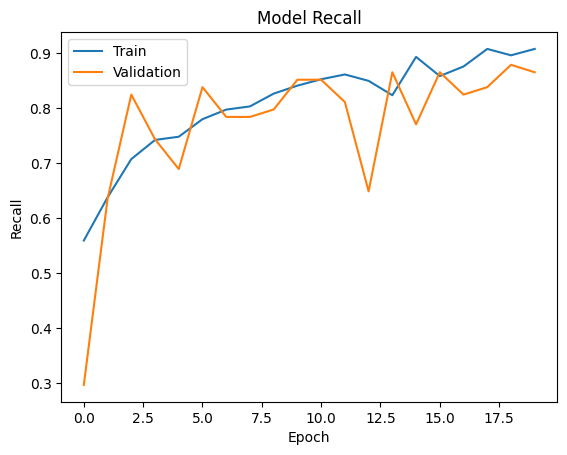

In [28]:
# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)

#  y_pred contains probabilities from a sigmoid output thus continous
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the results rounded to 2 decimal places
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


# Full classification report
# print(classification_report(y_test, y_pred, target_names=["Non-Flood", "Flood"]))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.89
Precision: 0.87
Recall: 0.92
F1-score: 0.89


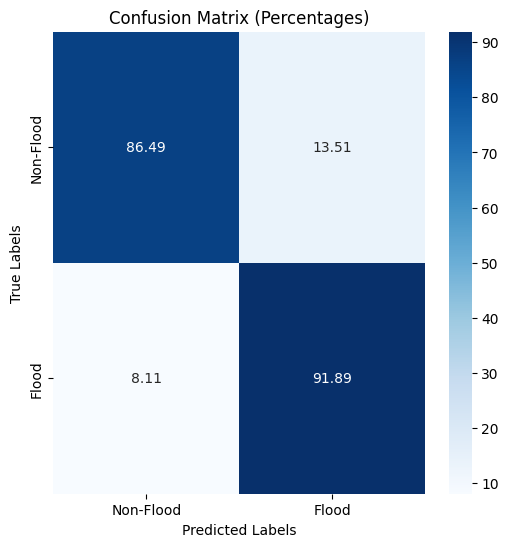

In [30]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(6, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Non-Flood", "Flood"], yticklabels=["Non-Flood", "Flood"])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [31]:
# Save the model
model.save('/content/drive/MyDrive/flood_classifier_model.keras')


In [33]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/flood_classifier_model.keras')


In [34]:
 from tensorflow.keras.preprocessing import image


# Load and preprocess a single image
img_path = '/content/drive/MyDrive/floor image test.jpg'
img = image.load_img(img_path, target_size=(128, 128))  # Resize image to (128, 128)
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize the image
# Predict using the model
predictions = model.predict(img_array)

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


array([[0.29693332]], dtype=float32)

In [35]:
# Assuming binary classification (flood vs. non-flood), check the prediction
if predictions[0] > 0.4:
    print("Predicted: Non-Flood")
else:
    print("Predicted: Flood")


Predicted: Flood
